<center>
    <h1>Health Outcomes at the County Level in Washington State
    <h2>Elbert Scot Carpenter
    <h3> December 12, 2024
</center>

----

## Summary

This research project analyzes data provided by County Health Rankings and Roadmaps that contain year-specific health outcome ranks and measures for each county within Washington state from 2015 to 2023.
The research questions for this project are:
- What are the differences in the top and bottom half of counties in health outcome rankings?
- How much of an impact do these factors have on the overall health of these counties?
- What change would have the greatest impact on a county’s ranking?

Through independent t-test and logistic regression models the factors that had the greatest impact on a county’s health outcome rating were identified. Understanding which health features lead to positive or negative health outcomes at the county level allows for local governments and health agencies to be strategic in how they allocate funding for community health initiatives. 


## Methodology

### Data Acquisition, Selection, and Storage

The data used for this project was collected and aggregated from Excel spreadsheets provided by County Health Rankings and Roadmaps (County Health Rankings & Roadmaps). Each spreadsheet contained year-specific health outcome ranks and measures for each county within Washington state. County Health Rankings and Roadmaps provides data from 2010 to 2024. However, this project focuses on data collected between 2015 and 2023 due to inconsistencies in measures before 2015 and only preliminary data available for 2024. Features and counties included in the analysis were determined by data availability and the ability to explain specific metrics. For instance, the original dataset contains both `Number of Impaired Driving Deaths` and `% Alcohol Impaired`. Both features convey the same information in different forms, so in this case, and throughout the aggregated dataset, the percentage features were selected. After selecting features to be analyzed during the project careful inspection of the data integrity took place. Through this inspection it was found that the data that pertained to Garfield County contained a large amount of missing or marked as unreliable data. Due to the amount imputation or change in feature selection it would take to include this county, the decision was made to drop the county from the analysis. Specifics and code for extracting and aggregating the CSV files used in this notebook are provided in the supplemental notebook `Data Acquisition and Aggregation Notebook`.

To ensure the data was accessible and able to be manipulated throughout the project, the data from the CSV files were stored in defined `County` class objects. `County` objects are initialized with the county's name and their county-specific FIPS code. Once initialized, these objects contain fields structured as dictionaries. These dictionaries are indexed first by the year, then by the feature, providing the corresponding feature values. These class objects were essential in having all of the data readily available, eliminating the need to reference a separate file throughout the analysis. `County` class objects also include defined functions to access and manipulate their fields, load data into the objects, rank fields within the object, and create dataframes from dictionaries of `County` objects.

#### County Class

In [1]:
import pandas as pd

class County(object):
    
    def __init__(self, name, fip) :
        """
        County objects store county data from the FIPS address, name of county, list of years of records,
        list of the overall health ranking for specified years, dictionary of measures involved in rankings
        indexed by the year and then the name of the measure.
        """
        self.name = name
        self.fip = int(fip)
        self.years = []
        self.ranks = {}
        self.measures = {}
        self.population = {}
        
        
    def getName(self):
        return self.name
    
    
    def getFIP(self):
        return self.fip
    
    
    def addYear(self, year):
        if year not in self.years:
            self.years.append(year)
        else:
            print(f'{year} is already accounted for in {self.name}.')
    
    
    def getYears(self):
        return self.years
    
    
    def getRank(self, year, returnlist = False):
        if returnlist:
            return self.ranks
        else:
            return self.ranks[str(year)]
        
    def getPop(self, year):
        pop = self.population[str(year)]['Population']
        return int(pop)
    

    def setRank(self, year, rank):
        if year not in self.years:
            self.addYear(year)
        self.ranks[year] = rank
        
        
    def __str__(self):
        return f'County {self.name} has {self.ranks}.'

    
    @classmethod
    def loadData(cls, filePath, countyDict, field):
        """
        This function is used to populate the dictionary of County objects' designated field.
        """
        with open(filePath, 'r') as inFile:
            # Extract the features from the header.
            features = inFile.readline().strip().split(',')[3:]
                
            # Iterate through each line and extract the feature values.
            for line in inFile.readlines():
                # Initialize an empty dictionary to store values.
                workingDict = {feature: 0 for feature in features}
                line = line.strip().split(',')
                name = line[1]
                year = str(line[2])
                
                # Logic for excluding Garfield county.
                if name == 'Garfield':
                    continue
                
                # Add features to the dictionary.
                for i in range(len(line[3:])):
                    workingDict[features[i]] = line[i + 3]
                
                # Check if the county exists in countyDict otherwise create a new County object.
                if name not in countyDict:
                    countyDict[name] = cls(name, line[0])
                    
                # Set to appropriate class field
                if field.lower() == 'ranks':
                    countyDict[name].setRank(year, int(line[3]))
                else:
                    getattr(countyDict[name], field)[year] = workingDict  

                    
    @staticmethod
    def adjustRankings(rankedList):
        """
        This function assumes that its lone parameter is a sorted list of tuples containing
        rank and name of county. Then corrects and returns the ranks of the County objects 
        included in the analysis.
        """
        # Initialize the list to store the correct rankings.
        adjustedList = []
        
        # For loop to iterate through the ranked list and change ranks when needed.
        for expectedRank, (actualRank, name) in enumerate(rankedList, start = 1):
            if actualRank != expectedRank:
                adjustedList.append((expectedRank, name))
            else:
                adjustedList.append((actualRank, name))
                
        return adjustedList
    
    
    @staticmethod
    def sortedRankings(countyDict, year, verbose = False):
        """
        This function assumes that countyDict is a dictionary of County objects
        indexed by name. Then sorts the objects by rank of specified year. 
        This function invokes adjustRankings to correct the rankings used for analysis.
        Then returns a list of tuples containing the rank and name of county, as well
        as a dataframe that is constructed with the health rank, name, population, and
        population rank.
        """
        # Sort counties based on the rank for the specified year.
        sortedCounties = sorted(countyDict.items(), key = lambda x: x[1].getRank(year))

        # Create list of tuples.
        rankedList = [(county.getRank(year), name) for name, county in sortedCounties]
        
        # Adjust rankings for missing County.
        rankedList = County.adjustRankings(rankedList)
        
        # Get data to populate dataframe.
        rankedData = {
                'Health Rank': [rank for rank, name in rankedList],
                'Name': [name for rank, name in rankedList],
                'Population': [countyDict[name].getPop(year) for rank, name in rankedList]
            }
        
        # Initialize dataframe.
        rankedDF = pd.DataFrame(rankedData)
        
        # Add a Population Rank column to dataframe.
        rankedDF['Population Rank'] = rankedDF['Population'].rank(ascending=False).astype(int)

        # Report.
        if verbose:
            print(f'County Rank and Population for the year {year}:')
            display(rankedDF.style.hide(axis = 'index'))
            
        return rankedList, rankedDF
    
    
    @staticmethod
    def getTopBotDF(countyDict, yearRange):
        """
        This function assumes that countyDict is a dictionary of County objects
        indexed by name. Then creates three dataframes containing data from 
        specified years.
        """
        # Check and set expected structure for dataframe creation.
        if len(yearRange) == 1:
            allData, topData, botData = {}, {}, {}
            dicts = True
            years = yearRange
        else:
            allData, topData, botData = [], [], []
            dicts = False
                
        # For loop to iterate through each year in range to populate dataframes.
        for year in yearRange:
            # Convert year to string to ensure proper indexing.
            indexYear = str(year)
            # Get the top and bottom of each year.
            rankings, __ = County.sortedRankings(countyDict, year, False)
            # Get the top and bottom half of the County rankings.
            halves = int(len(rankings) / 2)
            top = [name for rank, name in rankings[:halves]]
            bot = [name for rank, name in rankings[-halves:]]
            
            # Get corrected rankings from rankings list.
            healthRank = {name: rank for rank, name in rankings}
            
            # For loop to populate top counties structure.
            for name in top:
                # Copy the dictionary from ranked measures.
                combinedData = countyDict[name].measures[indexYear].copy()
                # Add population and health rank.
                combinedData.update(countyDict[name].population[indexYear])
                combinedData['Health Rank'] = healthRank[name]
                # Attach label to row.
                combinedData['Label'] = 'Top'
                # Add to the outer structure.
                if dicts:
                    topData[name] = combinedData
                    allData[name] = combinedData
                else:
                    topData.append(combinedData)
                    allData.append(combinedData)
                        
            # For loop to populate bottom counties outer structure.
            for name in bot:
                # Copy the dictionary from ranked measures.
                combinedData = countyDict[name].measures[indexYear].copy()
                # Add population and health rank.
                combinedData.update(countyDict[name].population[indexYear])
                combinedData['Health Rank'] = healthRank[name]
                # Attach label to row.
                combinedData['Label'] = 'Bottom'
                # Add to the outer structures.
                if dicts:
                        botData[name] = combinedData
                        allData[name] = combinedData
                else:
                    botData.append(combinedData)
                    allData.append(combinedData)
                        
        # Logic for how to convert data into dataframe.            
        if dicts:
            allDataDF = pd.DataFrame.from_dict(allData, orient = 'index')
            topDataDF = pd.DataFrame.from_dict(topData, orient = 'index')
            botDataDF = pd.DataFrame.from_dict(botData, orient = 'index')
        else:
            allDataDF = pd.DataFrame(allData)
            topDataDF = pd.DataFrame(topData)
            botDataDF = pd.DataFrame(botData)

        # Reset the indexes.
        if dicts:
            allDataDF.reset_index(inplace=True)
            allDataDF.rename(columns={'index':'Name'}, inplace=True)
            topDataDF.reset_index(inplace=True)
            topDataDF.rename(columns={'index':'Name'}, inplace=True)
            botDataDF.reset_index(inplace=True)
            botDataDF.rename(columns={'index':'Name'}, inplace=True)

        # Ensure columns are numeric.
        for col in allDataDF.columns:
            if col not in ['Name', 'Label']:
                allDataDF[col] = pd.to_numeric(allDataDF[col])
        for col in topDataDF.columns:
            if col not in ['Name', 'Label']:
                topDataDF[col] = pd.to_numeric(topDataDF[col])
        for col in botDataDF.columns:
            if col not in ['Name', 'Label']:
                botDataDF[col] = pd.to_numeric(botDataDF[col])
                
        return allDataDF, topDataDF, botDataDF   

### Loading in the Data

In [2]:
# Initialize Dictionary to store County objects, indexed by county name.
countyDict = {}

# Load Dictionary of County objects.
County.loadData('aggregated_data/Washington_Health_Outcome_Rankings_2015-2023.csv', countyDict, 'ranks')
County.loadData('aggregated_data/Washington_Ranked_Measure_Data_2015-2023.csv', countyDict, 'measures')
County.loadData('aggregated_data/Washington_Population_Data_2015-2023.csv', countyDict, 'population')

### Exploring the Data

First feature to be explored is the `Rank` of each county, which is a measure of the county's length and quality of life. This feature is accompanied with the `Population` of the county to see if there is a potential correlation between the health outcome `Rank` and the `Population` of the county.

In [3]:
__, rankedDF23 = County.sortedRankings(countyDict, 2023, True)

County Rank and Population for the year 2023:


Health Rank,Name,Population,Population Rank
1,San Juan,18557,32
2,King,2252305,1
3,Douglas,43696,25
4,Island,87432,15
5,Whitman,47873,22
6,Kitsap,274314,7
7,Skagit,130696,11
8,Snohomish,833540,3
9,Clark,511404,5
10,Benton,210025,10


An intial peek into a county's rank compared to its population shows that having a high population does not guarantee a high health outcome rank. King County which has Seattle, Washington's most populated city and has `Population Rank` 1, is behind San Juan County in `Health Rank` and has a `Population Rank` of 32. Looking near the bottom of the health rankings, Yakima County is in the bottom ten in `Health Rank` but sits at number 8 for `Population Rank`. These values are based only on the year 2023, maybe looking at these `Health Rank` and `Population` over multiple years will give more insight. 

In [4]:
# Create DataFrames for rest of analysis.
# Assign range of years for analysis.
years = range(2015, 2024)

# The first dataframe will be used now, and the other two will be used later in the analysis.
allCounties, topCounties, botCounties = County.getTopBotDF(countyDict,years)

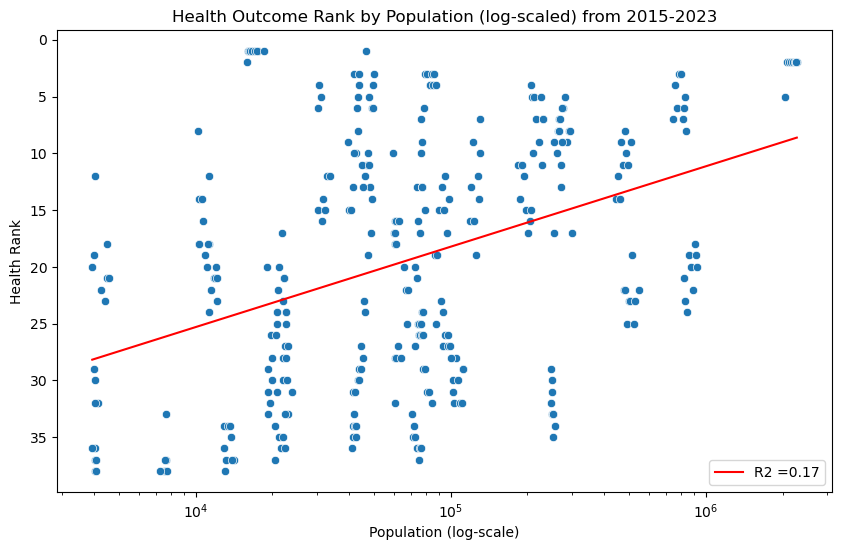

R2: 0.1653278923837027
MSE: 100.36932094085975


In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Transform the Population data and get target values.
logX = np.log(allCounties['Population']).values.reshape(-1, 1)
y = allCounties['Health Rank']    

# Initialize and fit Linear Regression model.
lm = LinearRegression()
lm.fit(logX, y)

# Predict the health rank.
preds = lm.predict(logX)

# Calculate r2 and mse.
r2 = r2_score(y, preds)
mse = mean_squared_error(y, preds)

# Plot values and add line from linear model.
plt.figure(figsize = (10, 6))
sns.scatterplot(x = 'Population', y = 'Health Rank', data = allCounties)
sns.lineplot(x = allCounties['Population'], y = preds, color = 'red', label = f'R2 ={r2:.2f}')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title('Health Outcome Rank by Population (log-scaled) from 2015-2023')
plt.xlabel('Population (log-scale)')
plt.ylabel('Health Rank')
plt.legend(loc = 'lower right')
plt.show()

# Report r2 and mse values.
print(f'R2: {r2}')
print(f'MSE: {mse}')


The linear regression model reveals that, while there appears to be a moderate positive correlation between county `Population` and `Health Rank`, the regression line with an r-squared of approximately 0.17 does not explain a large amount of the variance in the data. Additionally, the MSE of about 100 is quite high considering the range of possible `Health Rank` values. This indicates that county `Population` is a poor predictor of `Health Rank`.

Now to take a more guided approach and create a correlation matrix and heatmap to examine the correlations between the County features and `Health Rank`.

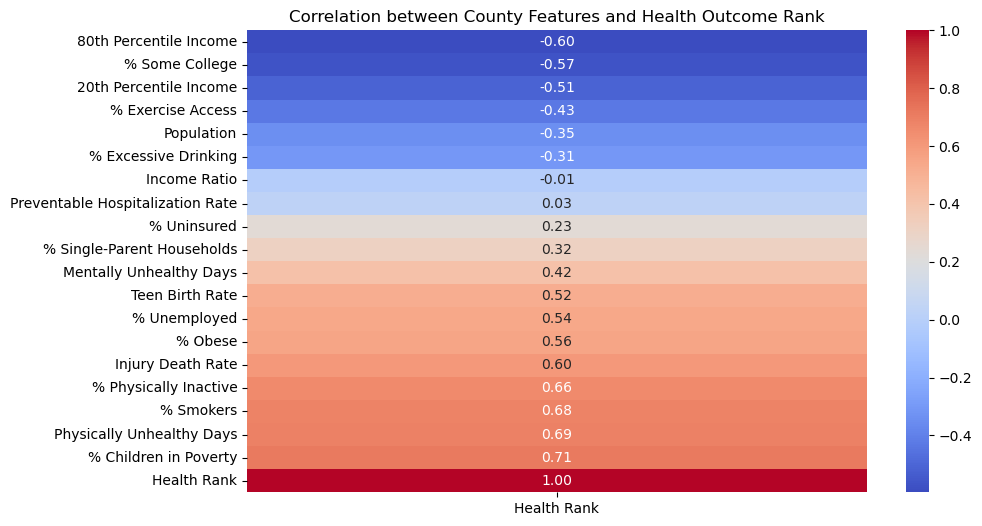

In [6]:
# Drop Label for matrix.
allCountiesNumeric = allCounties.drop(columns = ['Label'])

# Create correlation matrix for heatmap that focuses on Health Rank, sort ascending to convey relationship.
corrMatrix = allCountiesNumeric.corr()[['Health Rank']].sort_values(by = 'Health Rank', ascending = True)

# Plot heatmap.
plt.figure(figsize = (10, 6))
sns.heatmap(corrMatrix, annot = True, fmt = '.2f', cmap = 'coolwarm')
plt.title('Correlation between County Features and Health Outcome Rank')
plt.show()

The heatmap above shows the correlations between the `County` features and the target feature of `Health Rank`. The values on the plot are inverted because the lower the value for `Health Rank`, the higher the rank actually is. The heatmap reveals a slight correlation between `Health Rank` and `Population`. However, the strongest correlation to `Health Rank` is `% Children in Poverty`. This correlation is positive meaning that the higher the `% Children in Poverty`, the higher (and worse) the `Health Rank` will be. Now to take a look if `% Children in Poverty` can be a better predictor for `Health Rank`.

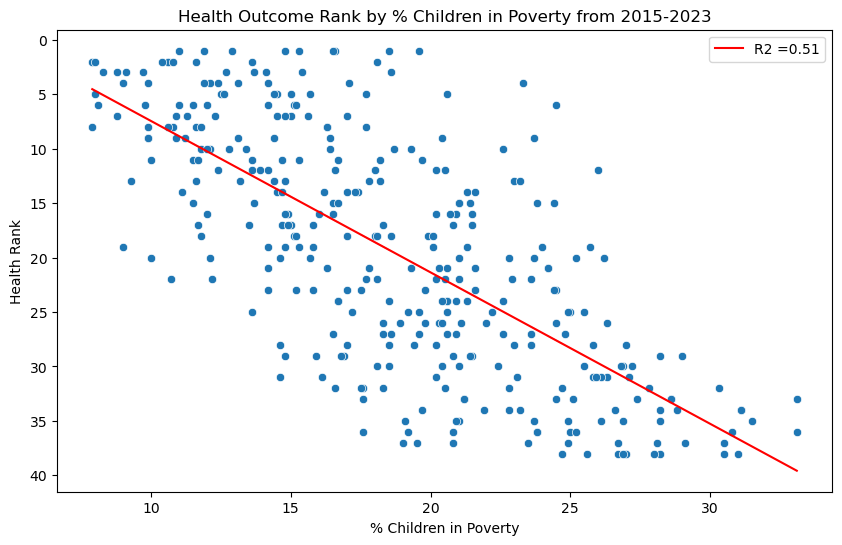

R2: 0.5096605200003173
MSE: 58.96332246996186


In [7]:
# Get x and y values for model.
x = allCounties['% Children in Poverty'].values.reshape(-1, 1)
y = allCounties['Health Rank']    

# Initialize and fit Linear Regression model.
lm = LinearRegression()
lm.fit(x, y)

# Predict the health rank.
preds = lm.predict(x)

# Calculate r2 and mse.
r2 = r2_score(y, preds)
mse = mean_squared_error(y, preds)

# Plot values and add line from linear model.
plt.figure(figsize = (10, 6))
sns.scatterplot(x = '% Children in Poverty', y = 'Health Rank', data = allCounties)
sns.lineplot(x = allCounties['% Children in Poverty'], y = preds, color = 'red', label = f'R2 ={r2:.2f}')
plt.gca().invert_yaxis()
plt.title('Health Outcome Rank by % Children in Poverty from 2015-2023')
plt.xlabel('% Children in Poverty')
plt.ylabel('Health Rank')
plt.legend(loc = 'upper right')
plt.show()

# Report r2 and mse values.
print(f'R2: {r2}')
print(f'MSE: {mse}')

The linear regression model for `% Children in Poverty` and `Health Outcome Rank` has an r-squared of approximately 0.51 and an MSE of around 59, indicating a strong negative correlation. When compared to the previous model with an r-squared of around 0.17 and an MSE of 100, this model explains much more of the variance in the data and provides predictions that are significantly closer to the actual values than the previous linear model that used `Population` as a predictor.

The previous plots and regression models suggest that counties that have a higher `Health Rank` have different values for `% Children in Poverty`. This will be examined through the boxplots comparing `% Children in Poverty` between counties that rank in the top and bottom half of `Health Rank`.

In [8]:
def reportStats(df_top, df_bot, features, stats, group_top, group_bot):
    """
    This function assumes that the two dataframes have the same features as the
    list of features parameter, and that a list of desired stats to reported on are values
    returned by the describe() dataframe function.
    """
    # Get the summary statistics for both datasets.
    dfStats_top = df_top[features].describe()
    dfStats_bot = df_bot[features].describe()
    
    # Create separate DataFrames for each statistic.
    stat_dfs = {}
    for stat in stats:
        stat_cap = stat.capitalize()
        stat_df = pd.DataFrame({
            f'{group_top}': dfStats_top.loc[stat],
            f'{group_bot}': dfStats_bot.loc[stat],
            f'Difference': dfStats_top.loc[stat] - dfStats_bot.loc[stat]
        })
        stat_dfs[stat_cap] = stat_df

    # Print the summary tables
    for stat, stat_df in stat_dfs.items():
        if stat == '50%':
            stat = 'Median'
        print(f'Difference in {stat} Values for Top and Bottom Counties in Washington State (2015-2023):\n')
        display(stat_df)
        print() 

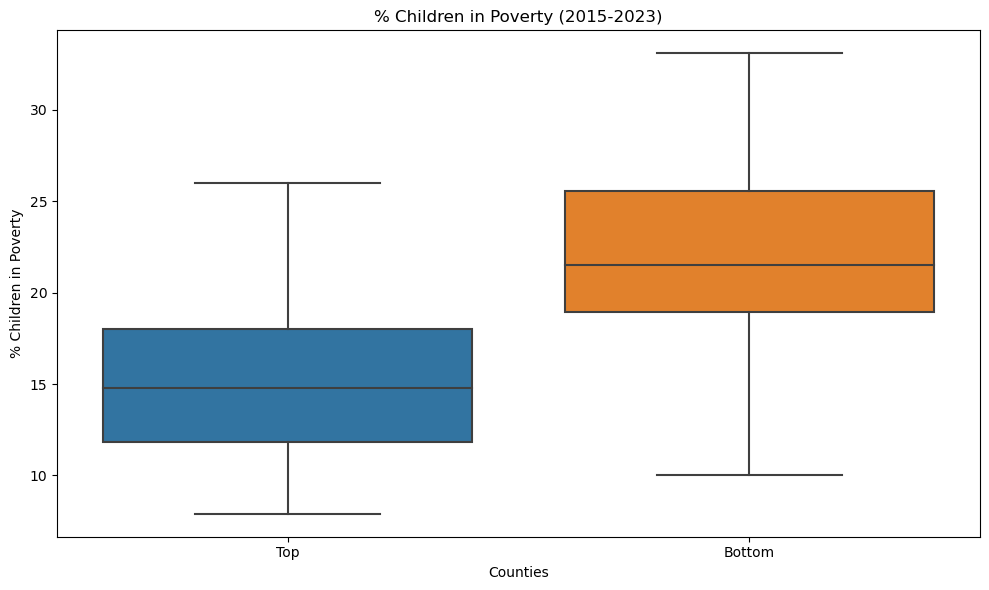

Difference in Median Values for Top and Bottom Counties in Washington State (2015-2023):



,Top,Bottom,Difference
% Children in Poverty,14.8,21.5,-6.7


In [9]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Label', y = '% Children in Poverty', data = allCounties)
plt.title('% Children in Poverty (2015-2023)')
plt.xlabel('Counties')
plt.tight_layout()
plt.show()

reportStats(topCounties, botCounties, ['% Children in Poverty'], ['50%'], 'Top', 'Bottom')

The box plots reveal that the interquartile ranges of the two groups are not aligned. Descriptive statistics show that counties in the bottom half of the `Health Rank` have a median of 6.7% more `% Children in Poverty` compared to those in the top half. Before conducting statistical tests on these two groups, the distribution of the values will be examined.

Text(0.5, 1.0, 'Distribution of % Children in Poverty between Top and Bottom Counties from 2015-2023')

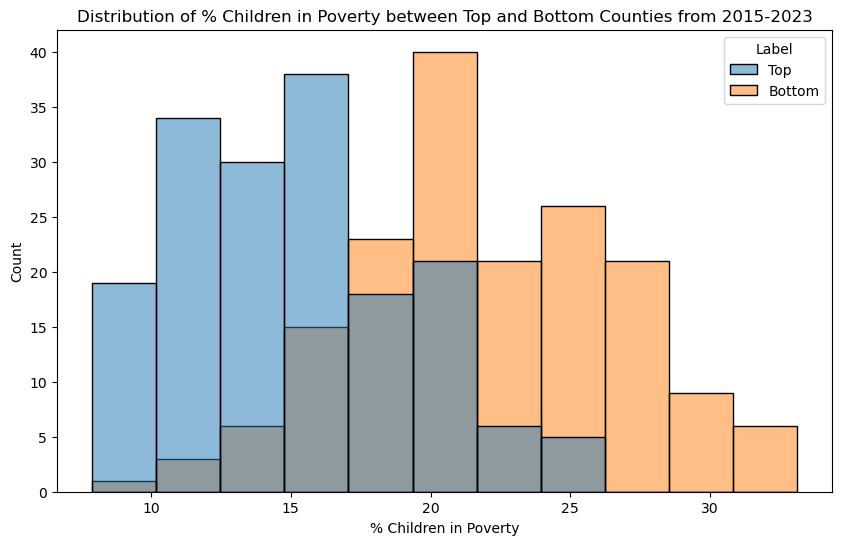

In [10]:
plt.figure(figsize = (10, 6))
sns.histplot(data = allCounties, x = '% Children in Poverty', hue = 'Label')
plt.title('Distribution of % Children in Poverty between Top and Bottom Counties from 2015-2023')

The distribution of the two groups shows that each group is relatively normal, with the top group having a slight left skew. Each distribution has a peak that does not align with the other, and neither has any clear outliers. An independent t-test will be run on these two groups to determine if there is a statistically significant difference between them.

### Statistical Analysis

#### Hypothesis Testing

In [11]:
from scipy.stats import ttest_ind

def runTTest(featA, featB, alpha):
    """
    This funcion assumes that the two features passed are arrays from a dataframe,
    and that a float is passed for the significance value alpha. Returns a tuple 
    of the p-value and a boolean of whether the statistic is significant or not.
    """
    # Run t-test.
    t, p = ttest_ind(featA, featB)
    
    # Logic for return value.
    if p < alpha:
        return p, True
    else:
        return p, False

def runMultiTTest(dfA, dfB, features, alpha, verbose = True, plot = False):
    """
    This function assumes that the two dataframes passed have the same features 
    as the lists of features passed as an arguement, and that a float is passed 
    for the significance value alpha. Returns a list of features that are found
    to be significantly statistically different.
    """
    # Get the new alpha based on the Bonferroni Correction.
    newAlpha = alpha / len(features)
    
    # Initialize lists of features.
    sigFeats = []
    inSigFeats = []
    
    # For loop to iterate through test features and add to appropriate list.
    for feature in features:
        # Run t-test.
        p, result = runTTest(dfA[feature], dfB[feature], newAlpha)
        # Logic for determining significant features.
        if result:
            sigFeats.append((feature, p))
        else:
            inSigFeats.append((feature, p))
    
    # Sort the results with the most significant first.
    sortedSigFeats = sorted(sigFeats, key = lambda x: x[1])
    sortedInSigFeats = sorted(inSigFeats, key = lambda x: x[1])
    
    # Report Results.
    if verbose:
        print(f'New significance level with the Bonferroni Correction: {newAlpha}')
        print('Significant Features:')
        if sigFeats:
            for feat, p in sortedSigFeats:
                print(f'{feat}: {p}')
        else:
            print('No features were found to be statistically significant.')
        print('\nInsignificant Features:')
        if inSigFeats:
            for feat, p in sortedInSigFeats:
                print(f'{feat}: {p}')
        else:
            print('No features were found to be statistically insignificant.')
            
    if plot:
        # Plot the log-scaled p-values.
        # Get arrays of the features and p-values.
        feats = [feat for feat, p in sortedSigFeats]
        pVals = [p for feat, p in sortedSigFeats]
        
        # Scale the p-values to make low values more noticable in the plot.
        logP = np.log(pVals)
        # Normalize values to have the color scale show more difference in values.
        normalizedP = plt.Normalize(np.min(logP), np.max(logP))
        colors = plt.cm.viridis_r(normalizedP(logP))
        
        plt.figure(figsize = (10, 6))
        sns.barplot(y = feats, x = pVals, palette = colors)
        # Scale the values.
        plt.xscale('log')
        plt.xlabel('Log Scaled p-value')
        plt.ylabel('County Features')
        plt.title('Log Scaled p-values for Features between Top and Bottom Counties')
        plt.show()
            
    return sortedSigFeats

The goal of these independent t-tests is to determine if the values for the features between the two groups, `Top Counties` and `Bottom Counties`, are significantly different. The null hypothesis is that there is no difference in the values between these two groups, while the alternative hypothesis is that there is a difference. The threshold for significance will be determined by alpha, which is initially set at 0.05. However, since multiple t-tests are being conducted, the threshold needs to be adjusted to avoid a Type I error. This adjustment will be made using the Bonferroni Correction, which divides the initial alpha by the number of tests being conducted. This results in a new alpha of approximately 0.0026.

$$H_0 = \mu_{Top} = \mu_{Bot}$$
$$H_A = \mu_{Top} \neq \mu_{Bot}$$

In [12]:
# Perform independent t-tests on features inside of dataset.
# Initialize intial alpha.
alpha = 0.05

# Get name of features to test.
testFeats = allCounties.drop(columns = ['Label', 'Health Rank']).columns

# Run Multiple t-tests and get significant features.
__ = runMultiTTest(topCounties, botCounties, testFeats, alpha)

New significance level with the Bonferroni Correction: 0.002631578947368421
Significant Features:
% Children in Poverty: 3.018846676902239e-37
% Physically Inactive: 6.691184789714892e-35
% Smokers: 1.4572986122386464e-33
Physically Unhealthy Days: 1.8592949932838398e-32
Injury Death Rate: 5.421799049203056e-25
80th Percentile Income: 1.651733257900458e-23
% Some College: 3.6067870340194455e-22
% Obese: 1.1901868096744195e-21
Teen Birth Rate: 5.51907720849364e-19
% Unemployed: 2.0159938976943714e-17
20th Percentile Income: 3.954272722391673e-17
% Exercise Access: 3.1147373178236324e-12
Mentally Unhealthy Days: 4.652215223944747e-11
% Single-Parent Households: 3.709976937012555e-08
% Excessive Drinking: 3.7040214896711415e-07
Population: 1.1992451872020555e-05
% Uninsured: 0.0003542692602061689

Insignificant Features:
Income Ratio: 0.5877903172296075
Preventable Hospitalization Rate: 0.904243918757554


For all features except `Income Ratio` and `Preventable Hospitalization Rate`, the null hypothesis was rejected. Although the p-values for each feature are reported, they are so small that it is difficult to discern the differences between them. To better illustrate the differences among the most significant features, a bar plot will be provided. This plot will logarithmically scale the p-values, highlighting the features that are truly the most significantly different between the two groups.

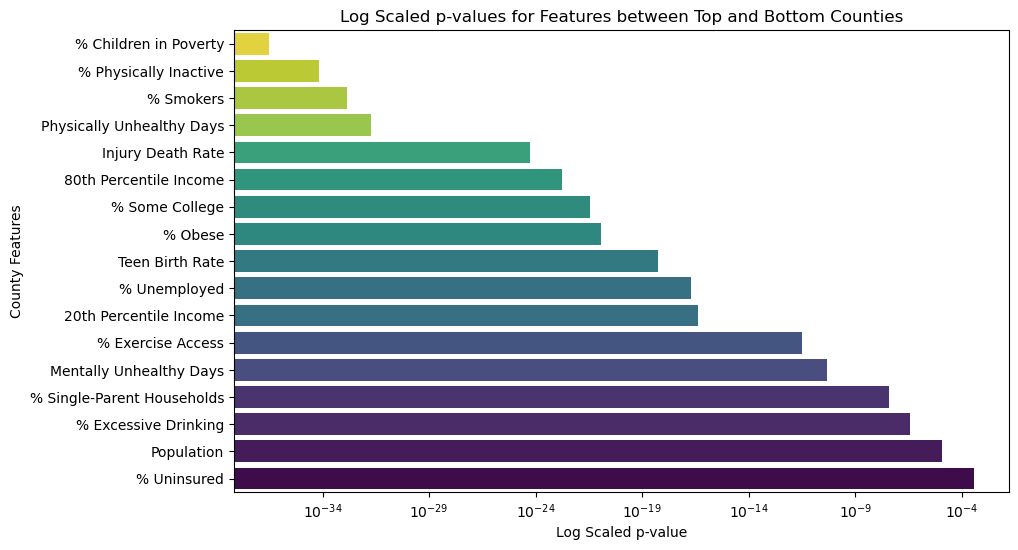

In [13]:
# Run multiple t-tests again to show the plot.
sigFeats = runMultiTTest(topCounties, botCounties, testFeats, alpha, verbose = False, plot = True)

While all of these features were found to be significant, there are clear differences in their magnitudes. The features `% Children in Poverty`, `% Physically Inactive`, `% Smokers`, and `Physically Unhealthy Days` have much smaller p-values compared to the rest of the features tested. These features are could provide the most value in determining which counties belong to either the `Top` or `Bottom` county groups.

In [14]:
# Get the features to focus on.
focusFeatNames = [feat for feat, val in sigFeats[:4]]

# Give descriptive statistics for the most focus features.
reportStats(topCounties, botCounties, focusFeatNames, ['50%'], 'Top', 'Bottom')

Difference in Median Values for Top and Bottom Counties in Washington State (2015-2023):



,Top,Bottom,Difference
% Children in Poverty,14.800000,21.500000,-6.700000
% Physically Inactive,17.500000,22.000000,-4.500000
% Smokers,14.113566,16.700000,-2.586434
Physically Unhealthy Days,3.697150,4.212243,-0.515093


Further exploring these four features shows that the top counties have:

* -6.7% difference in median `% Children in Poverty`.

* -4.5% difference in median `% Physically Inactive`.

* -2.6% difference in median `% Smokers`.

* -0.5% difference in median `Physically Unhealthy Days`.

#### Logistic Regression

Two Logistic Regression models will be constructed. One model will use all features that were found to be significant (`sigFeats`), while the other will use only the top 4 most significant features (`focusFeats`). These models will be evaluated and compared based on their mean accuracy and AUROC scores, obtained by randomly sampling training and test sets 10 times.

In [17]:
# Prep dataframes for modeling.
# Convert labels to 1s and 0s.
allCounties['Label'] = allCounties['Label'].map({'Top': 1, 'Bottom' : 0})

# Get significant features names only.
sigFeatNames = [feat for feat, val in sigFeats]

# Create dataframes that hold the different features, and that hold the target.
focusFeats = allCounties[focusFeatNames]
sigFeats = allCounties[sigFeatNames]
targets = allCounties['Label']

In [18]:
from scipy import stats

def computeCI(dataLst, confidence = 0.95):
    """
    This function assumes that the list is not empty and contains numerical data.
    Returns the mean, and the upper and lower bounds of confidence interval.
    """
    # Get number of datapoints, mean, and standard error.
    n = len(dataLst)
    mean = np.mean(dataLst)
    standErr = np.std(dataLst) / np.sqrt(n)
    
    # Calculate the Margin of Error.
    moe = standErr * stats.t.ppf((1 + confidence) / 2, n -1)
    
    # Calculate upper and lower bounds.
    lower = mean - moe
    upper = mean + moe
    
    return mean, lower, upper

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import numpy as np

# Initialize lists to hold metrics and number of random samples.
sigAccScores, sigROCAUCs, sigTPRs = [], [], []
focusAccScores, focusROCAUCs, focusTPRs = [], [], []
randomSamples = 10

# Metric for random classifier line.
meanFPR = np.linspace(0, 1, 100)

# For loop to conduct random sampling, splits, and evaluations.
for i in range(randomSamples):
    # Set a different random seed for each iteration.
    np.random.seed(i)
    
    # Split the data into training and test sets. Include a different state per iteration.
    sigTrainFeats, sigTestFeats, sigTrainTargets, sigTestTargets =\
    train_test_split(sigFeats, targets, test_size = 0.3, random_state = i)
    
    focusTrainFeats, focusTestFeats, focusTrainTargets, focusTestTargets =\
    train_test_split(focusFeats, targets, test_size = 0.3, random_state = i)
    
    # Initialize Scaler objects.
    sigScaler   = StandardScaler()
    focusScaler = StandardScaler()
    
    # Fit the scalers on training data and transform both training and test sets.
    # Significant Features.
    scaledSigTrainFeats = sigScaler.fit_transform(sigTrainFeats)
    scaledSigTestFeats  = sigScaler.transform(sigTestFeats)
    # Focus Features.
    scaledFocusTrainFeats = focusScaler.fit_transform(focusTrainFeats)
    scaledFocusTestFeats  = focusScaler.transform(focusTestFeats)
    
    # Initialize and fit Logistic Regression models.
    # Significant Features.
    sigLog = LogisticRegression()
    sigLog.fit(scaledSigTrainFeats, sigTrainTargets)
    # Focus Features.
    focusLog = LogisticRegression()
    focusLog.fit(scaledFocusTrainFeats, focusTrainTargets)
    
    # Get Predicted probabilities for ROC.
    sigProbas   = sigLog.predict_proba(scaledSigTestFeats)[:, 1]
    focusProbas = focusLog.predict_proba(scaledFocusTestFeats)[:, 1]
    
    # Calculate ROC and AUC.
    # Significant Features.
    sigFPR, sigTPR, sigThresh = roc_curve(sigTestTargets, sigProbas)
    sigTPRs.append(np.interp(meanFPR, sigFPR, sigTPR))
    sigTPRs[-1][0] = 0.0
    sigROCAUC = roc_auc_score(sigTestTargets, sigProbas)
    sigROCAUCs.append(sigROCAUC)
    # Focus Features.
    focusFPR, focusTPR, focusThresh = roc_curve(focusTestTargets, focusProbas)
    focusTPRs.append(np.interp(meanFPR, focusFPR, focusTPR))
    focusTPRs[-1][0] = 0.0
    focusROCAUC = roc_auc_score(focusTestTargets, focusProbas)
    focusROCAUCs.append(focusROCAUC)
    
    # Predict targets and calculate accuracy score.
    # Significant Features.
    sigPreds = sigLog.predict(scaledSigTestFeats)
    sigAcc = accuracy_score(sigTestTargets, sigPreds)
    sigAccScores.append(sigAcc)
    # Focus Features.
    focusPreds = focusLog.predict(scaledFocusTestFeats)
    focusAcc = accuracy_score(focusTestTargets, focusPreds)
    focusAccScores.append(focusAcc)


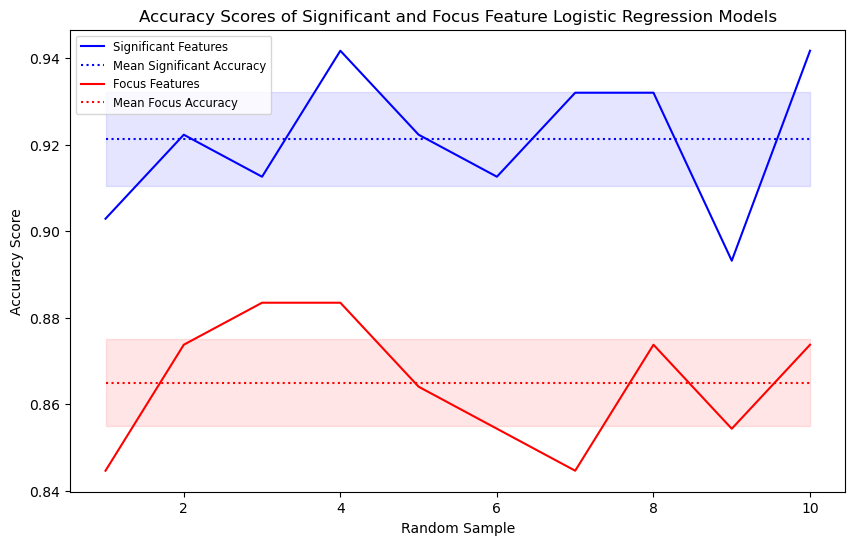

In [24]:
# Assign range to variable for plotting and initialize confidence level.
samples = range(1, randomSamples + 1)
confidence = 0.95

# Get mean, and confidence intervals of accuracy scores.
meanSigAcc, sigLower, sigUpper = computeCI(sigAccScores, confidence)
meanFocusAcc, focusLower, focusUpper = computeCI(focusAccScores)

# Plot Accurarcy scores, mean score, and shaded confidence intervals.
plt.figure(figsize = (10, 6))
# Significant Features.
sns.lineplot(x = samples, y = sigAccScores, color = 'blue', label = 'Significant Features')
sns.lineplot(x = samples, y = meanSigAcc, color = 'blue', linestyle = 'dotted', label = 'Mean Significant Accuracy')
plt.fill_between(samples, sigLower, sigUpper, color = 'blue', alpha = 0.1)
# Focus Features.
sns.lineplot(x = samples, y = focusAccScores, color = 'red', label = 'Focus Features')
sns.lineplot(x = samples, y = meanFocusAcc, color = 'red', linestyle = 'dotted', label = 'Mean Focus Accuracy')
plt.fill_between(samples, focusLower, focusUpper, color ='red', alpha = 0.1)

plt.title('Accuracy Scores of Significant and Focus Feature Logistic Regression Models')
plt.xlabel('Random Sample')
plt.ylabel('Accuracy Score')
plt.legend(loc = 'best', fontsize = 'small')
plt.show()

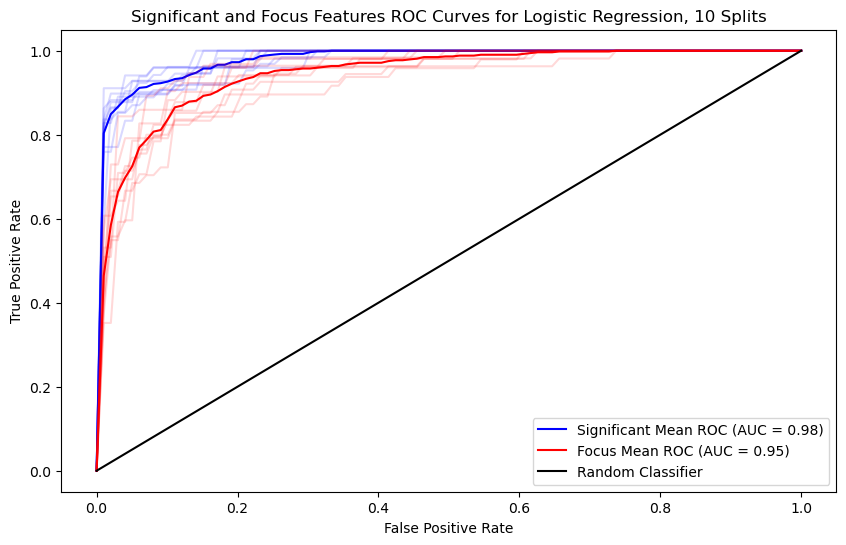

In [25]:
# Calculate the average ROC and AUC with confidence intervals.
meanSigTPR = np.mean(sigTPRs, axis=0)
meanSigTPR[-1] = 1.0
meanSigAUC, sigLowerAUC, sigUpperAUC = computeCI(sigROCAUCs)

meanFocusTPR = np.mean(focusTPRs, axis=0)
meanFocusTPR[-1] = 1.0
meanFocusAUC, focusLowerAUC, focusUpperAUC = computeCI(focusROCAUCs)

plt.figure(figsize = (10, 6))
# Plot all significant features ROC and mean ROC.
for tpr in sigTPRs:
    sns.lineplot(x = meanFPR, y = tpr, alpha = 0.15, color = 'blue')
sns.lineplot(x = meanFPR, y = meanSigTPR, color = 'blue', label = f'Significant Mean ROC (AUC = {meanSigAUC:.2f})')

# Plot all focus feature ROC and mean ROC.
for tpr in focusTPRs:
    sns.lineplot(x = meanFPR, y = tpr, alpha = 0.15, color = 'red')
sns.lineplot(x = meanFPR, y = meanFocusTPR, color = 'red', label = f'Focus Mean ROC (AUC = {meanFocusAUC:.2f})')

# Plot the random classifier line.
sns.lineplot(x = [0, 1], y = [0, 1], color = 'black', label = 'Random Classifier')

plt.title('Significant and Focus Features ROC Curves for Logistic Regression, 10 Splits')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'best')
plt.show()

In [80]:
# Get coefficients from Logistic Regression.
sigCoefs = sigLog.coef_[0]
sigLabels = sigTrainFeats.columns
focusCoefs = focusLog.coef_[0]
focusLabels = focusTrainFeats.columns

# Create DataFrame for Significant Features model coefficients.
sig_coef_df = pd.DataFrame({
    'Feature': sigLabels,
    'Coefficient': sigCoefs
})

# Create DataFrame for Focus Features model coefficients.
focus_coef_df = pd.DataFrame({
    'Feature': focusLabels,
    'Coefficient': focusCoefs
})

# Report metrics.
print(f'Results after Random Sampling {randomSamples} times')
print('Significant Features:')
print(f'\tMean Accuracy\t\t: {meanSigAcc:.2f} with {confidence * 100}% confidence interval ({sigLower:.2f}, {sigUpper:.2f})')
print(f'\tMean AUROC\t\t: {meanSigAUC:.2f} with {confidence * 100}% confidence interval ({sigLowerAUC:.2f}, {sigUpperAUC:.2f})')
print('Model Coefficients:')
display(sig_coef_df.style.hide(axis = 'index'))
print()
print('Focus Features:')
print(f'\tMean Accuracy\t: {meanFocusAcc:.2f} with {confidence * 100}% confidence interval ({focusLower:.2f}, {focusUpper:.2f})')
print(f'\tMean AUROC\t: {meanFocusAUC:.2f} with {confidence * 100}% confidence interval ({focusLowerAUC:.2f}, {focusUpperAUC:.2f})')
print('\nFocus Features Model Coefficients:')
display(focus_coef_df.style.hide(axis ='index'))

Results after Random Sampling 10 times
Significant Features:
	Mean Accuracy		: 0.92 with 95.0% confidence interval (0.91, 0.93)
	Mean ROCUC		: 0.98 with 95.0% confidence interval (0.98, 0.98)
Model Coefficients:


Feature,Coefficient
% Children in Poverty,-0.929698
% Physically Inactive,-0.723002
% Smokers,-1.241885
Physically Unhealthy Days,-0.668931
Injury Death Rate,-1.818676
80th Percentile Income,0.657339
% Some College,0.248784
% Obese,-0.718902
Teen Birth Rate,-1.391676
% Unemployed,-0.082992



Focus Features:
	Mean Accuracy	: 0.87 with 95.0% confidence interval (0.86, 0.88)
	Mean ROCUC	: 0.95 with 95.0% confidence interval (0.94, 0.96)

Focus Features Model Coefficients:


Feature,Coefficient
% Children in Poverty,-1.302333
% Physically Inactive,-1.113012
% Smokers,-1.446141
Physically Unhealthy Days,-0.620951


Both the logistic models performed at high accuracy. However, the `Significant Feature` model outperformed the `Focus Feature` model with a mean accuracy score of 92% and a confidence interval between 91% and 93%, compared to a mean accuracy score of 87% and confidence interval of 86% and 88%. The `Significant Feature` model also outperformed the `Focus Feature` model in mean AUC score, having a mean AUC of .98 compared to the `Focus Feature` model's mean AUC of .95. The `Significant Feature` model put most weight on the feature of `Injury Death Rate`, where as the `Focus Feature` model put the most weight on `% Smokers`, which was the 6th highest weight in the `Significant Feature` model.

The model that would be selected for futur predictions would be the `Significant Feature` model. This is due to the model having consistently high accuracy through random samples, and its high ability to distinguish between `Top` and `Bottom` counties inside of Washington State.

## Results, Discussion, Conclusion

The research questions for this project are:
What are the differences in the top and bottom half of counties in health outcome rankings?
How much of an impact do these factors have on the overall health of these counties?
What change would have the greatest impact on a county’s ranking?

The statistically significant differences in health outcome ranking between the top half and bottom half of counties in Washington are:
- Percent of children in poverty
- Percent of physically inactive people
- Percent of smoking adults
- Number of physically unhealthy days
- The injury death rate
- Adults in the 80th percentile income
- Percent of adults who have some college
- Percent of obese people
- Teen birth rate
- Percent of unemployed adults
- Adults in the 20th percentile income
- Percent with exercise access
- Number of mentally unhealthy days
- Percent of single-parent households
- Percent of excessive drinking
- Total population
- Percent of uninsured people

The first four features (percent of children in poverty, percent of physically inactive people, percent of smoking adults, and number of physically unhealthy days) have the most significant difference on health outcome rankings between top and bottom ranked counties. The difference in median between the top and bottom ranked counties are:
- Percent of children in poverty: -6.7%
- Percent of physically inactive people: -4.5%
- Percent of smoking adults: -2.6%
- Number of physically unhealthy days: -0.5%

Through logistic regression models, I achieved a mean accuracy of 92% with a 95% confidence interval ranging from 91% to 93%, and a mean AUROC of 98%. These models were used to classify Washington State counties into the top or bottom half of health outcome rankings. The following features were identified as having the highest coefficient weights:
- **Negative Coefficients**
    - Injury death rate: -1.818676
    - Teen birth rate: -1.391676
    - Number of mentally unhealthy days: -1.371530
    - Total population: -1.301660
    - Percent of smoking adults: -1.241885
- **Positive Coefficients**
    - Adults in the 80th percentile income: 0.657339
    - Adults in the 20th percentile income: 0.265468
    - Percent of adults who have some college: 0.248784


Higher ranked counties have fewer physically unhealthy days and lower percentages of children in poverty, physically inactive adults, and smoking adults. However, focusing on improving those metrics alone will not have as large a positive impact on a county’s health ranking. The logistic regression models reveal that most of the health features will decrease a county’s ranking instead of increase it; only three of 17 features had a positive coefficient. Improving income or increasing the percentage of adults enrolled in college is challenging, and alone will not have an outsize positive impact on health outcomes. Implementing a Universal Basic Income would be politically difficult, and college attendance relies on a multitude of factors such as affordability, academic preparedness, support structures, and family needs. Additionally, it is not feasible to lower a county’s population, nor is it straightforward to reduce the injury death rate.
	
However, targeting the features identified here as statistically significant can make substantial improvements to a county’s overall health. Lowering the teen birth rate through community outreach, free clinics, and education; organizing public awareness campaigns about existing resources for mental health support; or targeting teens and children with anti-smoking education paired with free smoking cessation programs and resources for existing smokers are all tangible steps that would improve a county’s health rankings. With any ranking system, there will always be a top half and a bottom half, even if health disparities are reduced. But examining the differences in the health factors, such as the percentage of children in poverty, gives a better indication of where the health disparities lie and where the biggest impact could be made for each dollar spent in community programs.


## References

County Health Rankings & Roadmaps. (n.d.). Data and resources: Washington. County Health
Rankings & Roadmaps. Retrieved October 28, 2024, from
https://www.countyhealthrankings.org/health-data/washington/data-and-resources
